In [1]:
import sys
sys.path.append('../..')

# reload sf import while I'm working on extracting functionality to it from notebooks
from importlib import reload
import sf_lib; import sf_lib.sf; import sf_lib.df
reload(sf_lib), reload(sf_lib.sf), reload(sf_lib.df)

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import date

from sf_lib.df import (
    make_df_classify, 
    make_df_tasks_with_props
)
from sf_lib.sf import (
    get_running_vote_fraction,
    getFilename, 
    getMetadataValue, 
    parseTime, 
    getGroupSize, 
    extractTaskValue
)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load auxiliary data, like object info and names of targets in the catalogue

In [2]:
object_info = pd.read_csv('../../catalogue/sf_spacefluff_object_data.csv', comment="#")
candidate_names_classify = np.loadtxt('../sf_candidate_names__classification-classify.txt', dtype='str')
catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')

### Define tasks so we can load the dataframes properly

<span style="color: red;"><strong>IMPORTANT!</strong></span> When we go to combine the three dataframes, make sure to swap the names of the T1 and T2 columns in the `hardcore` workflow. For some reason, The question assigned to T1 in `Classify!` is assigned to T2 in `Hardcore`. If we don't swap them, we'll end up with useless data.

In [3]:
tasks_hardcore = [0, 2, 1, 3, 4, 5, 9]
tasks_classify = [0, 1]
tasks_onthego = [0]

### Load dataframes

In [4]:
df_classify = make_df_classify('classify', tasks_classify)
df_hardcore = make_df_classify('hardcore', tasks_hardcore)
df_onthego = make_df_classify('onthego', tasks_onthego)

#### Swap T1 and T2 columns in `hardcore` workflow

In [5]:
df_hardcore[['T1', 'T2']] = df_hardcore[['T2', 'T1']]

### Stack the three dataframes

Note the following inconsistency: `onthego` formulates one of the _task 0_ answers as "Group of objects (cluster)", while `classify` and `hardcore` have it formulated with uppercase 'C': "Group of objects (Cluster)". Fix this by just coercing all answers to lowercase.

In [6]:
df = df_classify.append(df_hardcore).append(df_onthego)
df['T0'] = df['T0'].apply(lambda x: x.lower())

## Find duplicate classifications of an object made by the same user across workflows

For ease of readability, I won't be coding the most efficient way time-complexity wise. 

In [7]:
# slice dataframe columns we need for much faster indexing
groupby_user = df[['user_name', 'Filename', 'T0']].groupby('user_name')
unique_users = df['user_name'].unique()

In [8]:
# loop through groups to find users who made more classifications than they saw unique objects,
# i.e. they saw at least one object multiple times

users_with_duplicates = []

for user in unique_users:
    clas = groupby_user.get_group(user)
    objects_seen = clas['Filename']
    if not objects_seen.shape[0] == objects_seen.unique().shape[0]:
        users_with_duplicates.append(user)

### Generate a list with each user and the objects they saw multiple times:

In [10]:
duplicate_classifications = {user: [] for user in users_with_duplicates}

for user in users_with_duplicates:
    clas = groupby_user.get_group(user)
    objects = clas['Filename']
    
    objects_seen = []
    for obj in objects:
        if not obj in objects_seen:
            objects_seen.append(obj)
        else:
            duplicate_classifications[user].append(obj)      

In [9]:
# len(users_with_duplicates)

233

Discovery: 233 users saw the same object multiple times across workflows.

### Generate a list of the number of duplicate objects the users above saw:

In [11]:
# duplicate_count = [len(objects) for [user, objects] in duplicate_classifications.items()]    

#### Print the frequency of duplicate votes (first entry is # of duplicates seen by user, second is the amount of users that saw that many duplicate objects)

In [12]:
# duplicate_count_frequency = np.unique(duplicate_count, return_counts=True)
# # print(np.array(duplicate_count_frequency).T)

Discovery: there is one user that saw 4363 duplicate objects, and one that saw 2046 duplicates. What happened here?

### Loop through all duplicate classifications and extract classification_id of every classification where the user had already seen that object:

In [15]:
to_filter = []  # ids will be appeneded to this list

for user, dupes in duplicate_classifications.items():
    seen = []

    # query df by username and filename to get these objects
    vals = df.query("user_name == @user & Filename.isin(@dupes)")[['Filename', 'classification_id']].values
    for entry in vals:
        name, _id = entry
        if name in seen:
            to_filter.append(_id)
        else:
            seen.append(name)

## Filter all classifications where user had already seen that object:

In [16]:
df = df.query("~classification_id.isin(@to_filter)")

# Rewrite creation of 'df_tasks_with_props' for stacked dataframe
beats wasting hours messing with df_tasks_with_props code from before

In [17]:
task_strings_hc = ['T{}'.format(t) for t in tasks_hardcore]
task_strings_classify = ['T0', 'T1']

def df_votes_with_vote_count(df_votes):
    df_votes.insert(1, 'vote_count', df_votes['T0'].apply(lambda x: sum(list(x.values()))))
    
    return df_votes

def df_votes_with_object_info(df_votes):
    df_votes = df_votes.merge(object_info, how='outer', on='name')
    df_votes = df_votes.query("~vote_count.isnull()")
    
    return df_votes

def df_votes_with_t0_counts(df_votes, t0_answers):
    for t in t0_answers:
        col_name = '# votes {}'.format(t)
        df_votes[col_name] = df_votes['T0'].apply(lambda x: x.get(t, 0))

    for t in t0_answers:
        col_name = '% votes {}'.format(t)
        df_votes[col_name] = round(100*df_votes['# votes {}'.format(t)]/df_votes['vote_count'], 1)
        
    return df_votes

def make_df_votes(df, task_strings):
    t0_answers = df['T0'].unique().tolist()
    gr = df[['Filename', *task_strings]].groupby('Filename')
    
    vals_list = []
    for name in df['Filename'].unique().tolist():
        vals = { "name": name }
        for task in tasks_hardcore:
            t = 'T{}'.format(task)
            vals[t] = gr.get_group(name)[t].value_counts().to_dict()

        vals_list.append(vals)

    df_votes = pd.DataFrame(vals_list)

    df_votes = df_votes_with_vote_count(df_votes)
    df_votes = df_votes_with_object_info(df_votes)
    df_votes = df_votes_with_t0_counts(df_votes, t0_answers)
    
    return df_votes

# @todo: keep a list of classifications of the same object made after the first time the user saw it, so we can exlude those classifications

Discovery: there are 10316 classifications (approx. 5% of the total, actually, way  more than I expected) made by users that had already seen that object at least once.

In [18]:
df_votes = make_df_votes(df, task_strings_hc)

In [24]:
def get_answer_vote_percentage(row, entry, decimal_places=1):
    none_count = row.get('None', 0)
    total_votes = sum(row.values())
    actual_votes = total_votes - none_count
    
    if actual_votes > 0:
        return round(100*row.get(entry, 0)/actual_votes, decimal_places)

tasks_hardcore = [0, 2, 1, 3, 4, 5, 9]
task_strings = ['T{}'.format(t) for t in tasks_hardcore]

def add_vote_percentages(df_votes, df):
    for task in task_strings:
        for entry in df.query("~{}.isnull()".format(task))[task].unique().tolist():
            df_votes["{} % {}".format(task, entry.lower())] = df_votes[task].apply(lambda x: get_answer_vote_percentage(x,  entry))

In [25]:
add_vote_percentages(df_votes, df)

In [33]:
def df_to_json(df, path):
    df.to_json(path)

In [34]:
df_to_json(df_votes, 'df_votes.json')

In [36]:
df.reset_index(drop=True, inplace=True)
df_to_json(df, 'df_stacked.json')

---

### Extract usernames of users that saw more than 1000 duplicates:

In [13]:
# strange_users = list(filter(lambda entry: len(entry[1]) > 1000, duplicate_classifications.items()))
# strange_users = [user[0] for user in strange_users]

#### Print number of votes cast per option for T0 (task 0) by these users:

In [14]:
# for user in strange_users:
#     print('\n')
#     print(df.query("user_name == @user")['T0'].value_counts().to_dict())
#     print('# votes by user:', df.query("user_name == @user").shape[0])



{'galaxy': 6488, 'group of objects (cluster)': 2450, 'something else/empty center': 1376}
# votes by user: 10314


{'galaxy': 5141, 'group of objects (cluster)': 1744, 'something else/empty center': 921}
# votes by user: 7806


# @idea: plot distribution of votes per user between galaxy, group, empty center as a function of votes per user

Discovery (cells deleted): classification may have retired state without me having noticed it

## Plot properties

In [20]:
def get_cols(df, cols):
    return df[cols].T.values

In [21]:
def fancy_plot(x, y, 
   xlabel, ylabel, title, 
   hist1=None, hist2=None, 
   savepath=None, 
   figsize=(12,8), 
   invert_x=True, invert_y=True
):
    if not hist1:
        hist1 = x
    if not hist2:
        hist2 = y

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(5,5, wspace=0, hspace=0)

    fr1 = fig.add_subplot(gs[:-1,1:])
    fr2 = fig.add_subplot(gs[:-1, 0])
    fr3 = fig.add_subplot(gs[-1, 1:])

    common_hist_args = {
        "bins": 50, 
        "color": '#ddd',
        'histtype': 'step',
        "edgecolor": '#333'
    }

    common_args = {
        's': 6,
        "alpha": 0.6,
        "marker": "D",
    #     "facecolors": 'xkcd:lightish blue',
        "facecolors": 'none',
        "edgecolors": "xkcd:lightish blue",
        "lw": 1
    }

    fr2.hist(y, orientation='horizontal', **common_hist_args)
    fr3.hist(x, **common_hist_args)

    fr1.scatter(x, y, **common_args)
    fr1.grid(alpha=0.3, which='both')
    
    # fr1.set_ylabel(r'$\mu_{e,r}$ [mag arcsec$^{-2}$]', fontsize=10)

    fr1.set_xlabel(xlabel, bbox={'alpha': 0.75, 'color': 'white'}, fontsize=12)
    fr1.set_ylabel(ylabel, bbox={'alpha': 0.75, 'color': 'white'}, fontsize=12)

    tick_params = {
        "pad": -15,
        "left": "off",
        "labelleft": "on"
    }
    
    fr1.tick_params(axis="y", pad=-25, left='off', labelleft='off')
    fr1.tick_params(axis="x", **tick_params)

    if invert_x:
        fr1.set_xlim(fr1.get_xlim()[::-1])
        fr3.set_xlim(fr3.get_xlim()[::-1])
        
    if invert_y:
        fr1.set_ylim(fr1.get_ylim()[::-1])
        fr2.set_ylim(fr2.get_ylim()[::-1])
        
    fr2.set_xlim(fr2.get_xlim()[::-1])
    fr3.set_ylim(fr3.get_ylim()[::-1])

    fr2.set_axis_off()
    fr3.set_axis_off()

#     fr1.set_zorder(100)
    # plt.setp(fr1.get_xticklabels(), bbox={'alpha': 0.7,'color': 'white'})
    # plt.setp(fr1.get_yticklabels(), bbox={'alpha': 0.7,'color': 'white'})

    fr1.set_title(title)
    fig.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=400)
        
    plt.show()

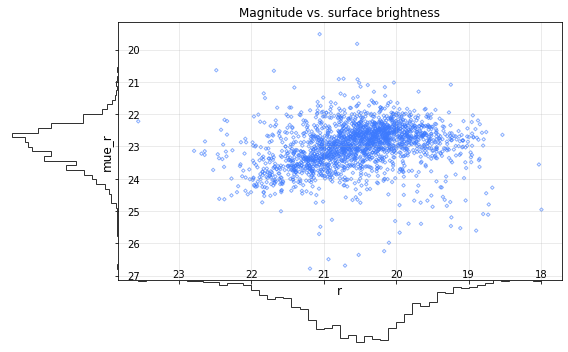

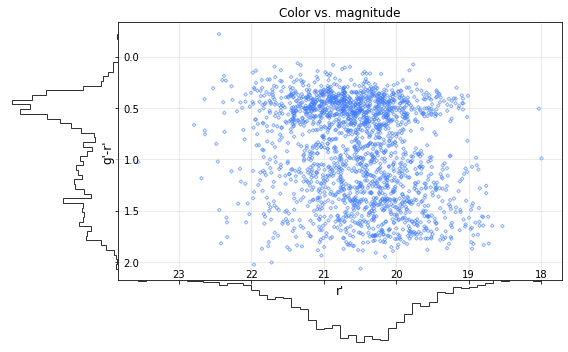

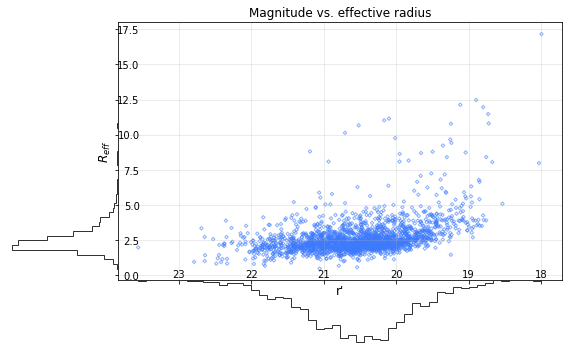

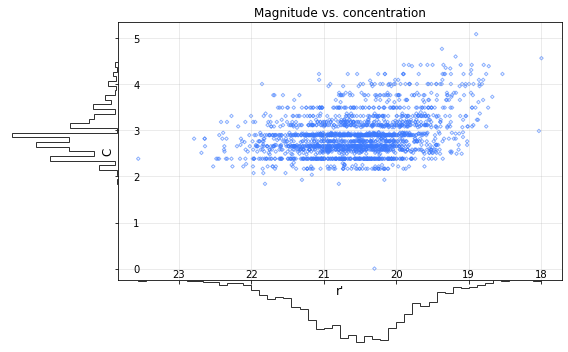

In [22]:
q = "`% votes galaxy` >= 75"  # query
cols = ['mue_r', 'r', 'g', 'Reff', 'C']
mue_r, r, g, Reff, C = get_cols(df_votes.query(q), cols)

fancy_plot(r, mue_r, xlabel='r', ylabel='mue_r', title="Magnitude vs. surface brightness", figsize=(8,5))
fancy_plot(r, g-r, "r'", "g'-r'", 'Color vs. magnitude', figsize=(8,5))
fancy_plot(r, Reff, "r'", r"$R_{eff}$", 'Magnitude vs. effective radius', figsize=(8,5), invert_y=False)
fancy_plot(r, C, "r'", "C", 'Magnitude vs. concentration', figsize=(8,5), invert_y=False)

## Plots

In [31]:
q = "`% votes galaxy` > 75 & `% Fluffy` > 75"

fluffies_stacked = df_votes.query(q)['name'].tolist()

UndefinedVariableError: name 'BACKTICK_QUOTED_STRING__PERCENT__Fluffy' is not defined

In [ ]:
fluffies_in_catalogue = set(fluffies_stacked) & set(catalogue_targets)

In [ ]:
lacks_votes = []

sf_names = set(df['Filename'])
for name in set(catalogue_targets):
    if not name in sf_names:
        lacks_votes.append(name)
        
print(len(lacks_votes))

In [ ]:
print(len(catalogue_targets))

Discovery: of the 265 `UDGcand_*` objects in selective catalogue, 33 aren't even present in our dataset. This leaves 232 objects that are classified in SpaceFluff. Keep this in mind for our statistics.

## Compare `hardcore` consensus to that in `stacked`

In [ ]:
fluf_hc = df_votes_hc.query("`% votes Galaxy` > 75 & `% Fluffy` > 75")

In [ ]:
intersect_hc_cat = set(fluf_hc['name']) & set(catalogue_targets)
intersect_stacked_cat = set(fluffies_stacked) & set(catalogue_targets)
len(intersect_hc_cat), len(intersect_stacked_cat)

Discovery: Only a few catalogue objects have the consensus 'fluffy galaxy' as per the users.

In [ ]:
kwargs = { "alpha": 0.5, "s": 7, "marker": 'D'}

r, mue_r = get_cols(fluf_hc, ['r', 'mue_r'])
fig,fr = plt.subplots()
fr.scatter(r, mue_r, **kwargs)


in_catalogue = df_votes.query('name.isin(@catalogue_targets)')
r, mue_r = get_cols(in_catalogue, ['r', 'mue_r'])
fr.scatter(r, mue_r, **kwargs)
fr.invert_xaxis()
fr.invert_yaxis()

## Stacked vs. catalogue:

In [ ]:
fig, fr = plt.subplots(figsize=(6,4))

kwargs = { 'histtype': 'step', 'lw': 2, "density": True, "alpha": 0.7 }

q = df_votes.query('`% votes galaxy` >= 75 & `% Fluffy` >= 75')
q_gal = df_votes.query('`% votes galaxy` >= 75')

[mue_r] = get_cols(q, ['mue_r'])
fr.hist(mue_r, **kwargs, label='fluffy consensus')

[mue_r] = get_cols(q_gal, ['mue_r'])
fr.hist(mue_r, **kwargs, label='galaxy consensus')

[mue_r] = get_cols(in_catalogue, ['mue_r'])
fr.hist(mue_r, **kwargs, label='catalogue')

fr.legend(loc='upper right')
fr.set_title('Surface brightness: catalogue vs. voter consensus "fluffy"')
fr.set_xlabel('mue_r')
fr.set_ylabel('normed count')

fig.tight_layout()
plt.show()

## Look at the stacked dataframe votes for the catalogue targets

In [ ]:
cat_votes = df_votes.query('name.isin(@catalogue_targets)')

In [ ]:
t0_answers = ['% votes group of objects (cluster)', '% votes galaxy', '% votes something else/empty center']

In [ ]:
fig, fr = plt.subplots(1,3, figsize=(9,3))

for i, ans in enumerate(t0_answers):
    fr[i].hist(cat_votes[ans], range=[0,100])

    fr[i].set_xlim(0, 100)
    fr[i].update({
        "xlabel": ans,
        "ylabel": "# of objects"
    })

fig.tight_layout()
plt.show()